# 1. Desafio Delivery Center: Food & Goods

Este projeto é resultado de um desafio do grupo de assinaturas Universidade dos Dados, feito a partir do dataset Delivery Center: Food & Goods orders in Brazil disponível no [Kaggle](https://www.kaggle.com/datasets/nosbielcs/brazilian-delivery-center) e enviado por [Nosbielcs](https://www.kaggle.com/nosbielcs).

![Imagem](https://images.unsplash.com/photo-1526367790999-0150786686a2?q=80&w=2071&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D)

## 1.1. O desafio

Trabalhamos em uma startup de delivery, em um time de dados centralizado que atende diversas áreas e recebemos algumas demandas:

- Numa ação de marketing, para atrair mais entregadores, vamos dar uma bonificação para os 20 entregadores que possuem maior distância percorrida ao todo. A bonificação vai variar de acordo com o tipo de profissional que ele é e o modelo que ele usa para se locomover (moto, bike, etc). Levante essas informações.
- Além disso, o time de Pricing precisa ajustar os valores pagos aos entregadores. Para isso, eles precisam da distribuição da distância média percorrida pelos motoqueiros separada por estado, já que cada região terá seu preço.
- Por fim, o CFO precisa de alguns indicadores de receita para apresentar para a diretoria executiva. Dentre esses indicadores, vocês precisarão levantar (1) a receita média e total separada por tipo (Food x Good), (2) A receita média e total por estado. Ou seja, são 4 tabelas ao todo.
- Se a empresa tem um gasto fixo de 5 reais por entrega, recebe 15% do valor de cada entrega como receita e, do total do lucro, distribui 20% em forma de bônus para os 2 mil funcionários, quanto cada um irá receber no período contido no dataset?


## 1.2. Importação das bibliotecas e carregamento dos dados

In [131]:
# Bibliotecas para tratar dados
import pandas as pd
import numpy as np
import datetime
import os

# Bibliotecas visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração para não exibir warnings
import warnings

warnings.filterwarnings('ignore')

# Configuração o estilo dos gráficos para ggplot
plt.style.use('ggplot')

# Configuração para exibir até 15 linhas de um DataFrame do Pandas
pd.set_option('display.max_rows', 20)

# Configuração para exibir todas as colunas de um DataFrame do Pandas
pd.set_option('display.max_columns', None)

In [132]:
deliveries = pd.read_csv("../data/raw/deliveries.csv", encoding = "iso-8859-1")
drivers = pd.read_csv("../data/raw/drivers.csv", encoding = "iso-8859-1")
hubs = pd.read_csv("../data/raw/hubs.csv", encoding = "iso-8859-1")
orders = pd.read_csv("../data/raw/orders.csv", encoding = "iso-8859-1")
payments = pd.read_csv("../data/raw/payments.csv", encoding = "iso-8859-1")
stores = pd.read_csv("../data/raw/stores.csv", encoding = "iso-8859-1")

# 2. Estrutura, limpeza e manipulação dos dados

## 2.1. Deliveries

### Estrutura

In [133]:
deliveries.shape

(378843, 5)

In [134]:
deliveries.head()

,delivery_id,delivery_order_id,driver_id,delivery_distance_meters,delivery_status
0,2174658,68413340,8378.0,5199.0,DELIVERED
1,2174660,68414309,2473.0,410.0,DELIVERED
2,2174661,68416230,7615.0,3784.0,DELIVERED
3,2174663,68412721,8378.0,5714.0,DELIVERED
4,2174675,68414018,10463.0,3746.0,DELIVERED


In [135]:
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378843 entries, 0 to 378842
Data columns (total 5 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   delivery_id               378843 non-null  int64  
 1   delivery_order_id         378843 non-null  int64  
 2   driver_id                 362957 non-null  float64
 3   delivery_distance_meters  378770 non-null  float64
 4   delivery_status           378843 non-null  object 
dtypes: float64(2), int64(2), object(1)
memory usage: 14.5+ MB


### Limpeza e manipulação

In [136]:
# Decidi eliminar entregas com driver_id e delivery_distance_meters nulos

deliveries.dropna(subset = ['driver_id', 'delivery_distance_meters'], inplace = True)

In [137]:
deliveries.reset_index()
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 362928 entries, 0 to 378842
Data columns (total 5 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   delivery_id               362928 non-null  int64  
 1   delivery_order_id         362928 non-null  int64  
 2   driver_id                 362928 non-null  float64
 3   delivery_distance_meters  362928 non-null  float64
 4   delivery_status           362928 non-null  object 
dtypes: float64(2), int64(2), object(1)
memory usage: 16.6+ MB


In [138]:
deliveries.duplicated().sum()

0

In [139]:
# Existe possibilidade valores extremos nas distâncias percorridas, vou checar com describe

deliveries.describe().T.round(4)

,count,mean,std,min,25%,50%,75%,max
delivery_id,362928.0,2.635871e+06,2.650984e+05,2174658.0,2406176.50,2641922.5,2862955.25,3144739.0
delivery_order_id,362928.0,8.225126e+07,7.009141e+06,68410055.0,76343876.25,83191526.0,87920142.50,93139817.0
driver_id,362928.0,2.100128e+04,1.552032e+04,133.0,7615.00,18754.0,31048.00,66459.0
delivery_distance_meters,362928.0,2.818972e+03,1.874356e+04,0.0,1172.00,2044.0,3419.00,7251291.0


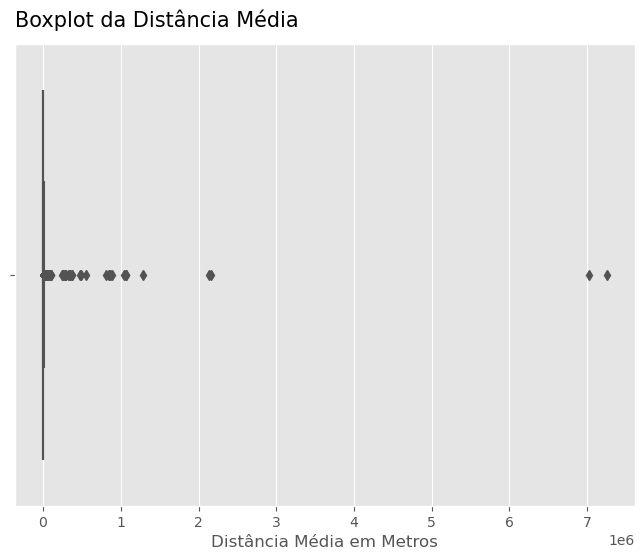

In [140]:
# Com um boxplot fica mais nítido a existência desses valores
# Portando vou buscar identificar e eliminar outliers

fig, ax = plt.subplots(figsize = (8, 6))

sns.boxplot(deliveries, x = 'delivery_distance_meters')
ax.set_title('Boxplot da Distância Média', fontsize = 15, pad = 12, loc = 'left')
ax.set_xlabel('Distância Média em Metros', fontsize = 12)
plt.show()

In [141]:
# Calculando intervalo interquatil
Q1 = deliveries['delivery_distance_meters'].quantile(0.25)
Q3 = deliveries['delivery_distance_meters'].quantile(0.75)
IQR = Q3 - Q1

# Calculando os limites inferior e superior
limite_inf = Q1 - 1.5 * IQR
limite_sup = Q3 + 1.5 * IQR

# Dados extremos
outliers = deliveries[(deliveries['delivery_distance_meters'] < limite_inf) | (deliveries['delivery_distance_meters'] > limite_sup)]
outliers.head()

,delivery_id,delivery_order_id,driver_id,delivery_distance_meters,delivery_status
784,2176595,68510957,26666.0,7222.0,DELIVERED
975,2177072,68537759,25651.0,7318.0,DELIVERED
998,2177145,68538927,655.0,7093.0,DELIVERED
1003,2177154,68538487,655.0,6999.0,DELIVERED
1006,2177159,68537700,15898.0,6796.0,DELIVERED


In [142]:
# Remoção dos valores extremos

deliveries_clean = deliveries[(deliveries['delivery_distance_meters'] >= limite_inf) & (deliveries['delivery_distance_meters'] <= limite_sup)].copy()
deliveries_clean.reset_index()
deliveries_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 346632 entries, 0 to 378842
Data columns (total 5 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   delivery_id               346632 non-null  int64  
 1   delivery_order_id         346632 non-null  int64  
 2   driver_id                 346632 non-null  float64
 3   delivery_distance_meters  346632 non-null  float64
 4   delivery_status           346632 non-null  object 
dtypes: float64(2), int64(2), object(1)
memory usage: 15.9+ MB


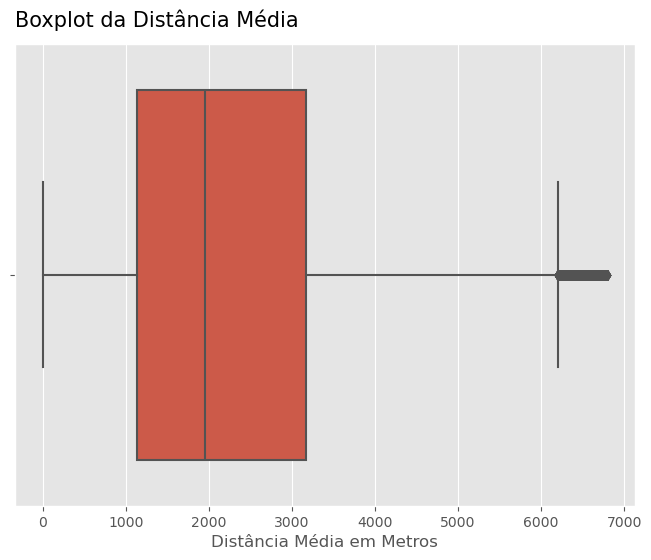

In [143]:
fig, ax = plt.subplots(figsize = (8, 6))

sns.boxplot(deliveries_clean, x = 'delivery_distance_meters')
ax.set_title('Boxplot da Distância Média', fontsize = 15, pad = 12, loc = 'left')
ax.set_xlabel('Distância Média em Metros', fontsize = 12)
plt.show()

In [144]:
deliveries_clean['delivery_status'].unique()

array(['DELIVERED', 'DELIVERING'], dtype=object)

In [145]:
deliveries_clean['delivery_status'].value_counts()

delivery_status
DELIVERED     346460
DELIVERING       172
Name: count, dtype: int64

In [146]:
# Vou manter apenas as entregas finalizadas

deliveries_clean = deliveries_clean[deliveries_clean['delivery_status'] == "DELIVERED"].copy()
deliveries_clean.head()

,delivery_id,delivery_order_id,driver_id,delivery_distance_meters,delivery_status
0,2174658,68413340,8378.0,5199.0,DELIVERED
1,2174660,68414309,2473.0,410.0,DELIVERED
2,2174661,68416230,7615.0,3784.0,DELIVERED
3,2174663,68412721,8378.0,5714.0,DELIVERED
4,2174675,68414018,10463.0,3746.0,DELIVERED


## 2.2. Drivers

### Estrutura

In [147]:
drivers.shape

(4824, 3)

In [148]:
drivers.head()

,driver_id,driver_modal,driver_type
0,133,MOTOBOY,LOGISTIC OPERATOR
1,138,MOTOBOY,FREELANCE
2,140,MOTOBOY,FREELANCE
3,143,BIKER,FREELANCE
4,148,MOTOBOY,FREELANCE


In [149]:
drivers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4824 entries, 0 to 4823
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   driver_id     4824 non-null   int64 
 1   driver_modal  4824 non-null   object
 2   driver_type   4824 non-null   object
dtypes: int64(1), object(2)
memory usage: 113.2+ KB


### Limpeza e manipulação

In [150]:
# driver_type não será útil para o nosso problema, então vou remover esta coluna

drivers = drivers[['driver_id', 'driver_modal']]
drivers.head()

,driver_id,driver_modal
0,133,MOTOBOY
1,138,MOTOBOY
2,140,MOTOBOY
3,143,BIKER
4,148,MOTOBOY


Não serão necessários outros tratamentos neste dataframe

## 2.3. Hubs

### Estrutura

In [151]:
hubs.shape

(32, 6)

In [152]:
hubs.head()

,hub_id,hub_name,hub_city,hub_state,hub_latitude,hub_longitude
0,2,BLUE SHOPPING,PORTO ALEGRE,RS,-30.047415,-51.213510
1,3,GREEN SHOPPING,PORTO ALEGRE,RS,-30.037415,-51.203520
2,4,RED SHOPPING,PORTO ALEGRE,RS,-30.021948,-51.208382
3,5,FUNK SHOPPING,RIO DE JANEIRO,RJ,-23.000750,-43.318282
4,8,GOLDEN SHOPPING,RIO DE JANEIRO,RJ,-22.921475,-43.234774


In [153]:
hubs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   hub_id         32 non-null     int64  
 1   hub_name       32 non-null     object 
 2   hub_city       32 non-null     object 
 3   hub_state      32 non-null     object 
 4   hub_latitude   32 non-null     float64
 5   hub_longitude  32 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.6+ KB


### Limpeza e manipulação

In [154]:
# Em hubs só será utilizado o hub_id e hub_state

hubs = hubs[['hub_id', 'hub_state']]
hubs.head()

,hub_id,hub_state
0,2,RS
1,3,RS
2,4,RS
3,5,RJ
4,8,RJ


## 2.4. Orders

### Estrutura

In [155]:
orders.shape

(368999, 29)

In [156]:
orders.head()

,order_id,store_id,channel_id,payment_order_id,delivery_order_id,order_status,order_amount,order_delivery_fee,order_delivery_cost,order_created_hour,order_created_minute,order_created_day,order_created_month,order_created_year,order_moment_created,order_moment_accepted,order_moment_ready,order_moment_collected,order_moment_in_expedition,order_moment_delivering,order_moment_delivered,order_moment_finished,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time
0,68405119,3512,5,68405119,68405119,CANCELED,62.7,0.0,NaN,0,1,1,1,2021,1/1/2021 12:01:36 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,68405123,3512,5,68405123,68405123,CANCELED,62.7,0.0,NaN,0,4,1,1,2021,1/1/2021 12:04:26 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,68405206,3512,5,68405206,68405206,CANCELED,115.5,0.0,NaN,0,13,1,1,2021,1/1/2021 12:13:07 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,68405465,3401,5,68405465,68405465,CANCELED,55.9,0.0,NaN,0,19,1,1,2021,1/1/2021 12:19:15 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,68406064,3401,5,68406064,68406064,CANCELED,37.9,0.0,NaN,0,26,1,1,2021,1/1/2021 12:26:25 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [157]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368999 entries, 0 to 368998
Data columns (total 29 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   order_id                           368999 non-null  int64  
 1   store_id                           368999 non-null  int64  
 2   channel_id                         368999 non-null  int64  
 3   payment_order_id                   368999 non-null  int64  
 4   delivery_order_id                  368999 non-null  int64  
 5   order_status                       368999 non-null  object 
 6   order_amount                       368999 non-null  float64
 7   order_delivery_fee                 368999 non-null  float64
 8   order_delivery_cost                361794 non-null  float64
 9   order_created_hour                 368999 non-null  int64  
 10  order_created_minute               368999 non-null  int64  
 11  order_created_day                  3689

### Limpeza e manipulação

Esse é o dataset mais extenso dos que temos acesso, dele irei também utilizar somente algumas colunas, após separar elas darei prosseguimento a mais processos de limpeza.

In [158]:
orders = orders[['order_id', 'store_id', 'payment_order_id', 'delivery_order_id', 'order_status', 
                 'order_created_day', 'order_created_month', 'order_created_year']]
orders.head()

,order_id,store_id,payment_order_id,delivery_order_id,order_status,order_created_day,order_created_month,order_created_year
0,68405119,3512,68405119,68405119,CANCELED,1,1,2021
1,68405123,3512,68405123,68405123,CANCELED,1,1,2021
2,68405206,3512,68405206,68405206,CANCELED,1,1,2021
3,68405465,3401,68405465,68405465,CANCELED,1,1,2021
4,68406064,3401,68406064,68406064,CANCELED,1,1,2021


In [159]:
orders.isna().sum()

order_id               0
store_id               0
payment_order_id       0
delivery_order_id      0
order_status           0
order_created_day      0
order_created_month    0
order_created_year     0
dtype: int64

In [160]:
orders.duplicated().sum()

0

In [161]:
# Vou criar uma coluna chamada order_date

orders['order_date'] = orders['order_created_year'].astype(str) + "-" + orders['order_created_month'].astype(str)\
+ "-" + orders['order_created_day'].astype(str)

orders.head()

,order_id,store_id,payment_order_id,delivery_order_id,order_status,order_created_day,order_created_month,order_created_year,order_date
0,68405119,3512,68405119,68405119,CANCELED,1,1,2021,2021-1-1
1,68405123,3512,68405123,68405123,CANCELED,1,1,2021,2021-1-1
2,68405206,3512,68405206,68405206,CANCELED,1,1,2021,2021-1-1
3,68405465,3401,68405465,68405465,CANCELED,1,1,2021,2021-1-1
4,68406064,3401,68406064,68406064,CANCELED,1,1,2021,2021-1-1


In [162]:
# Agora ela será convertida para datetime e o restante removida

orders.drop(columns = ['order_created_day', 'order_created_month', 'order_created_year'], axis = 1, inplace = True)
orders['order_date'] = pd.to_datetime(orders['order_date'])
orders.head()

,order_id,store_id,payment_order_id,delivery_order_id,order_status,order_date
0,68405119,3512,68405119,68405119,CANCELED,2021-01-01
1,68405123,3512,68405123,68405123,CANCELED,2021-01-01
2,68405206,3512,68405206,68405206,CANCELED,2021-01-01
3,68405465,3401,68405465,68405465,CANCELED,2021-01-01
4,68406064,3401,68406064,68406064,CANCELED,2021-01-01


In [163]:
orders['order_status'].unique()

array(['CANCELED', 'FINISHED'], dtype=object)

In [164]:
orders['order_status'].value_counts()

order_status
FINISHED    352020
CANCELED     16979
Name: count, dtype: int64

In [165]:
# Vou manter apenas as entregas finalizadas

orders = orders[orders['order_status'] == "FINISHED"]
orders.head()

,order_id,store_id,payment_order_id,delivery_order_id,order_status,order_date
8,68410055,2181,68410055,68410055,FINISHED,2021-01-01
17,68412721,631,68412721,68412721,FINISHED,2021-01-01
18,68413340,631,68413340,68413340,FINISHED,2021-01-01
19,68414018,3265,68414018,68414018,FINISHED,2021-01-01
20,68414309,236,68414309,68414309,FINISHED,2021-01-01


In [166]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 352020 entries, 8 to 368998
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   order_id           352020 non-null  int64         
 1   store_id           352020 non-null  int64         
 2   payment_order_id   352020 non-null  int64         
 3   delivery_order_id  352020 non-null  int64         
 4   order_status       352020 non-null  object        
 5   order_date         352020 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 18.8+ MB


## 2.5. Payments

### Estrutura

In [167]:
payments.shape

(400834, 6)

In [168]:
payments.head()

,payment_id,payment_order_id,payment_amount,payment_fee,payment_method,payment_status
0,4427917,68410055,118.44,0.00,VOUCHER,PAID
1,4427918,68410055,394.81,7.90,ONLINE,PAID
2,4427941,68412721,206.95,5.59,ONLINE,PAID
3,4427948,68413340,58.80,1.59,ONLINE,PAID
4,4427955,68414018,45.80,0.92,ONLINE,PAID


In [169]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400834 entries, 0 to 400833
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   payment_id        400834 non-null  int64  
 1   payment_order_id  400834 non-null  int64  
 2   payment_amount    400834 non-null  float64
 3   payment_fee       400659 non-null  float64
 4   payment_method    400834 non-null  object 
 5   payment_status    400834 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 18.3+ MB


In [170]:
# Novamente vou buscar valores extremos

payments[['payment_amount', 'payment_fee']].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
payment_amount,400834.0,93.09,221.95,0.0,32.70,65.88,121.40,100000.11
payment_fee,400659.0,1.88,4.54,0.0,0.44,1.04,2.71,2000.00


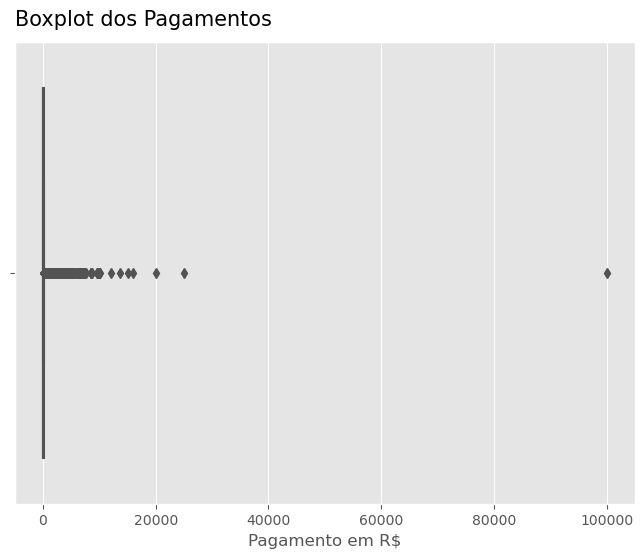

In [171]:
fig, ax = plt.subplots(figsize = (8, 6))

sns.boxplot(payments, x = 'payment_amount')
ax.set_title('Boxplot dos Pagamentos', fontsize = 15, pad = 12, loc = 'left')
ax.set_xlabel('Pagamento em R$', fontsize = 12)
plt.show()

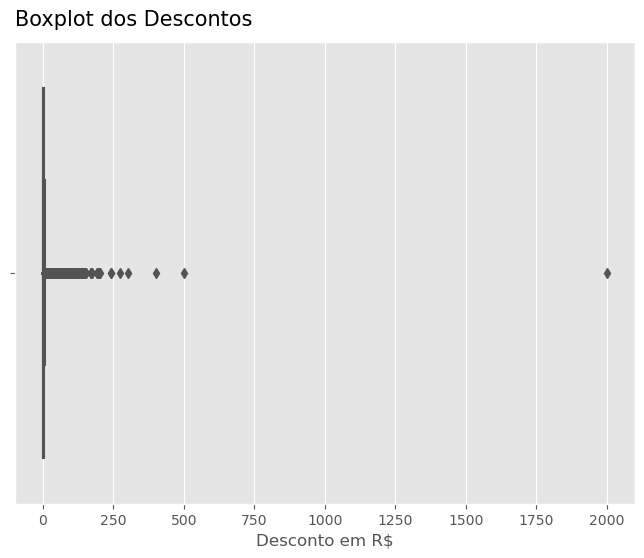

In [172]:
fig, ax = plt.subplots(figsize = (8, 6))

sns.boxplot(payments, x = 'payment_fee')
ax.set_title('Boxplot dos Descontos', fontsize = 15, pad = 12, loc = 'left')
ax.set_xlabel('Desconto em R$', fontsize = 12)
plt.show()

payment_fee é totalmente dependente de payment_amount, então vou aplicar primeiro o tratamento de outliers nessa coluna e ver como a outra vai se comportar.

In [173]:
# Calculando intervalo interquatil
Q1 = payments['payment_amount'].quantile(0.25)
Q3 = payments['payment_amount'].quantile(0.75)
IQR = Q3 - Q1

# Calculando os limites inferior e superior
limite_inf = Q1 - 1.5 * IQR
limite_sup = Q3 + 1.5 * IQR

# Dados extremos
outliers = payments[(payments['payment_amount'] < limite_inf) | (payments['payment_amount'] > limite_sup)]
outliers.head()

,payment_id,payment_order_id,payment_amount,payment_fee,payment_method,payment_status
1,4427918,68410055,394.81,7.90,ONLINE,PAID
76,4428184,68424659,281.90,7.61,ONLINE,PAID
86,4428218,68426299,340.90,5.11,ONLINE,PAID
168,4428432,68434849,681.60,18.40,ONLINE,PAID
190,4428493,68436739,362.00,9.77,ONLINE,PAID


In [174]:
payments_clean = payments[(payments['payment_amount'] >= limite_inf) & (payments['payment_amount'] <= limite_sup)].copy()
payments_clean.reset_index()
payments_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 383448 entries, 0 to 400833
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   payment_id        383448 non-null  int64  
 1   payment_order_id  383448 non-null  int64  
 2   payment_amount    383448 non-null  float64
 3   payment_fee       383294 non-null  float64
 4   payment_method    383448 non-null  object 
 5   payment_status    383448 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 20.5+ MB


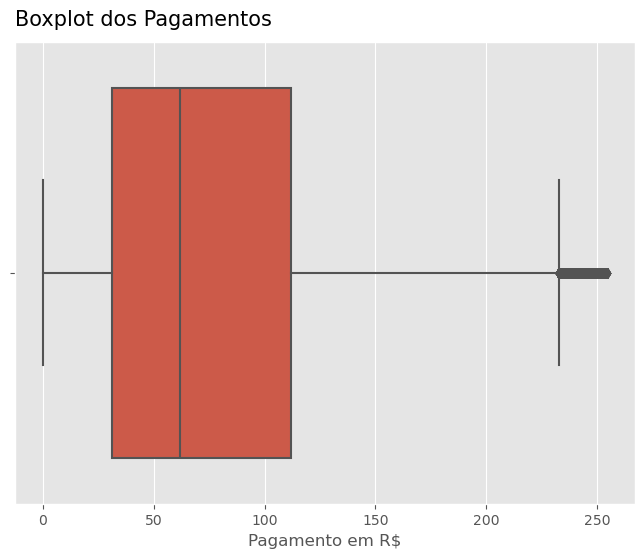

In [175]:
fig, ax = plt.subplots(figsize = (8, 6))

sns.boxplot(payments_clean, x = 'payment_amount')
ax.set_title('Boxplot dos Pagamentos', fontsize = 15, pad = 12, loc = 'left')
ax.set_xlabel('Pagamento em R$', fontsize = 12)
plt.show()

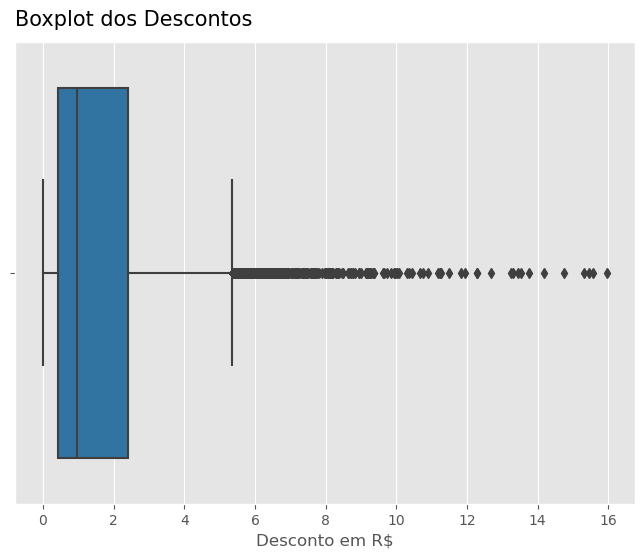

In [176]:
fig, ax = plt.subplots(figsize = (8, 6))

sns.boxplot(payments_clean, x = 'payment_fee', color = 'tab:blue')
ax.set_title('Boxplot dos Descontos', fontsize = 15, pad = 12, loc = 'left')
ax.set_xlabel('Desconto em R$', fontsize = 12)
plt.show()

Acredito não ser necessário mais uma rodada de limpeza de valores extremos, novamente pedidos nesse valor mais alto são razoáveis.

## 2.6. Stores

### Estrutura

In [177]:
stores.shape

(951, 7)

In [178]:
stores.head()

,store_id,hub_id,store_name,store_segment,store_plan_price,store_latitude,store_longitude
0,3,2,CUMIURI,FOOD,0.0,NaN,NaN
1,6,3,PIMGUCIS DA VIVA,FOOD,0.0,-30.037415,-51.203520
2,8,3,RASMUR S,FOOD,0.0,-30.037415,-51.203520
3,53,8,PAPA SUCIS,FOOD,0.0,-22.921475,-43.234822
4,54,8,VUZPI PAZZIS,FOOD,0.0,-22.921475,-43.234822


In [179]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951 entries, 0 to 950
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   store_id          951 non-null    int64  
 1   hub_id            951 non-null    int64  
 2   store_name        951 non-null    object 
 3   store_segment     951 non-null    object 
 4   store_plan_price  836 non-null    float64
 5   store_latitude    935 non-null    float64
 6   store_longitude   935 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 52.1+ KB


### Limpeza e manipulação

In [180]:
stores = stores[['store_id', 'hub_id', 'store_segment']]
stores.head()

,store_id,hub_id,store_segment
0,3,2,FOOD
1,6,3,FOOD
2,8,3,FOOD
3,53,8,FOOD
4,54,8,FOOD


## 2.7. Criando um dataset unificado

### Os critérios e ajustes para unir orders, deliveries e payments

O caminho que vou seguir é o seguinte: cada **pedido (order)**, segue para **entrega (deliveries_clean)** e ao final recebe um **pagamento (payments_clean)**.

In [181]:
orders.head(1)

,order_id,store_id,payment_order_id,delivery_order_id,order_status,order_date
8,68410055,2181,68410055,68410055,FINISHED,2021-01-01


In [182]:
deliveries_clean.head(1)

,delivery_id,delivery_order_id,driver_id,delivery_distance_meters,delivery_status
0,2174658,68413340,8378.0,5199.0,DELIVERED


In [183]:
payments_clean.head(1)

,payment_id,payment_order_id,payment_amount,payment_fee,payment_method,payment_status
0,4427917,68410055,118.44,0.0,VOUCHER,PAID


In [184]:
# Ajustando payments, e criando a coluna order_revenue

payments_clean = payments_clean[['payment_id', 'payment_order_id', 'payment_amount', 'payment_fee']]
payments_clean.head()

,payment_id,payment_order_id,payment_amount,payment_fee
0,4427917,68410055,118.44,0.00
2,4427941,68412721,206.95,5.59
3,4427948,68413340,58.80,1.59
4,4427955,68414018,45.80,0.92
5,4427956,68414309,106.80,2.88


In [185]:
payments_clean['order_revenue'] = ((payments_clean['payment_amount'] - payments_clean['payment_fee']) * 0.15) - 5
payments_clean.head()

,payment_id,payment_order_id,payment_amount,payment_fee,order_revenue
0,4427917,68410055,118.44,0.00,12.7660
2,4427941,68412721,206.95,5.59,25.2040
3,4427948,68413340,58.80,1.59,3.5815
4,4427955,68414018,45.80,0.92,1.7320
5,4427956,68414309,106.80,2.88,10.5880


### Unindo orders, deliveries e payments

In [186]:
df = orders.merge(deliveries_clean, on = 'delivery_order_id', how = 'inner')
df.head()

,order_id,store_id,payment_order_id,delivery_order_id,order_status,order_date,delivery_id,driver_id,delivery_distance_meters,delivery_status
0,68410055,2181,68410055,68410055,FINISHED,2021-01-01,2180133,10239.0,1035.0,DELIVERED
1,68412721,631,68412721,68412721,FINISHED,2021-01-01,2174663,8378.0,5714.0,DELIVERED
2,68413340,631,68413340,68413340,FINISHED,2021-01-01,2174658,8378.0,5199.0,DELIVERED
3,68414018,3265,68414018,68414018,FINISHED,2021-01-01,2174675,10463.0,3746.0,DELIVERED
4,68414309,236,68414309,68414309,FINISHED,2021-01-01,2174660,2473.0,410.0,DELIVERED


In [187]:
df.isna().sum()

order_id                    0
store_id                    0
payment_order_id            0
delivery_order_id           0
order_status                0
order_date                  0
delivery_id                 0
driver_id                   0
delivery_distance_meters    0
delivery_status             0
dtype: int64

In [188]:
df.duplicated().sum()

0

In [189]:
df = df.merge(payments_clean, on = 'payment_order_id', how = 'inner')
df.head()

,order_id,store_id,payment_order_id,delivery_order_id,order_status,order_date,delivery_id,driver_id,delivery_distance_meters,delivery_status,payment_id,payment_amount,payment_fee,order_revenue
0,68410055,2181,68410055,68410055,FINISHED,2021-01-01,2180133,10239.0,1035.0,DELIVERED,4427917,118.44,0.00,12.7660
1,68412721,631,68412721,68412721,FINISHED,2021-01-01,2174663,8378.0,5714.0,DELIVERED,4427941,206.95,5.59,25.2040
2,68413340,631,68413340,68413340,FINISHED,2021-01-01,2174658,8378.0,5199.0,DELIVERED,4427948,58.80,1.59,3.5815
3,68414018,3265,68414018,68414018,FINISHED,2021-01-01,2174675,10463.0,3746.0,DELIVERED,4427955,45.80,0.92,1.7320
4,68414309,236,68414309,68414309,FINISHED,2021-01-01,2174660,2473.0,410.0,DELIVERED,4427956,106.80,2.88,10.5880


In [190]:
df.isna().sum()

order_id                    0
store_id                    0
payment_order_id            0
delivery_order_id           0
order_status                0
order_date                  0
delivery_id                 0
driver_id                   0
delivery_distance_meters    0
delivery_status             0
payment_id                  0
payment_amount              0
payment_fee                 0
order_revenue               0
dtype: int64

In [191]:
df.duplicated().sum()

0

### Unindo hubs, stores e drivers

In [192]:
df = df.merge(drivers, on = 'driver_id', how = 'inner')
df.head()

,order_id,store_id,payment_order_id,delivery_order_id,order_status,order_date,delivery_id,driver_id,delivery_distance_meters,delivery_status,payment_id,payment_amount,payment_fee,order_revenue,driver_modal
0,68410055,2181,68410055,68410055,FINISHED,2021-01-01,2180133,10239.0,1035.0,DELIVERED,4427917,118.44,0.00,12.7660,BIKER
1,68627002,236,68627002,68627002,FINISHED,2021-01-02,2178772,10239.0,802.0,DELIVERED,4432396,147.60,3.99,16.5415,BIKER
2,68709624,1153,68709624,68709624,FINISHED,2021-01-02,2181160,10239.0,1211.0,DELIVERED,4435176,89.50,1.34,8.2240,BIKER
3,68785963,3728,68785963,68785963,FINISHED,2021-01-03,2183707,10239.0,417.0,DELIVERED,4438056,20.00,0.30,-2.0450,BIKER
4,68903420,236,68903420,68903420,FINISHED,2021-01-03,2186937,10239.0,1374.0,DELIVERED,4441343,91.80,2.48,8.3980,BIKER


In [193]:
df.isna().sum()

order_id                    0
store_id                    0
payment_order_id            0
delivery_order_id           0
order_status                0
order_date                  0
delivery_id                 0
driver_id                   0
delivery_distance_meters    0
delivery_status             0
payment_id                  0
payment_amount              0
payment_fee                 0
order_revenue               0
driver_modal                0
dtype: int64

In [194]:
df.duplicated().sum()

0

In [195]:
df = df.merge(stores, on = 'store_id', how = 'inner')
df.head()

,order_id,store_id,payment_order_id,delivery_order_id,order_status,order_date,delivery_id,driver_id,delivery_distance_meters,delivery_status,payment_id,payment_amount,payment_fee,order_revenue,driver_modal,hub_id,store_segment
0,68410055,2181,68410055,68410055,FINISHED,2021-01-01,2180133,10239.0,1035.0,DELIVERED,4427917,118.44,0.00,12.7660,BIKER,13,GOOD
1,70804201,2181,70804201,70804201,FINISHED,2021-01-12,2236161,14059.0,1612.0,DELIVERED,4496318,42.01,0.84,1.1755,BIKER,13,GOOD
2,85156722,2181,85156722,85156722,FINISHED,2021-03-21,2721137,938.0,422.0,DELIVERED,5041131,89.25,0.00,8.3875,BIKER,13,GOOD
3,85156722,2181,85156722,85156722,FINISHED,2021-03-21,2721137,938.0,422.0,DELIVERED,5041132,188.40,3.77,22.6945,BIKER,13,GOOD
4,84573921,2181,84573921,84573921,FINISHED,2021-03-18,2694843,2837.0,5938.0,DELIVERED,5013760,56.65,0.00,3.4975,MOTOBOY,13,GOOD


In [196]:
df.isna().sum()

order_id                    0
store_id                    0
payment_order_id            0
delivery_order_id           0
order_status                0
order_date                  0
delivery_id                 0
driver_id                   0
delivery_distance_meters    0
delivery_status             0
payment_id                  0
payment_amount              0
payment_fee                 0
order_revenue               0
driver_modal                0
hub_id                      0
store_segment               0
dtype: int64

In [197]:
df.duplicated().sum()

0

In [198]:
df = df.merge(hubs, on = 'hub_id', how = 'inner')
df.head()

,order_id,store_id,payment_order_id,delivery_order_id,order_status,order_date,delivery_id,driver_id,delivery_distance_meters,delivery_status,payment_id,payment_amount,payment_fee,order_revenue,driver_modal,hub_id,store_segment,hub_state
0,68410055,2181,68410055,68410055,FINISHED,2021-01-01,2180133,10239.0,1035.0,DELIVERED,4427917,118.44,0.00,12.7660,BIKER,13,GOOD,RJ
1,70804201,2181,70804201,70804201,FINISHED,2021-01-12,2236161,14059.0,1612.0,DELIVERED,4496318,42.01,0.84,1.1755,BIKER,13,GOOD,RJ
2,85156722,2181,85156722,85156722,FINISHED,2021-03-21,2721137,938.0,422.0,DELIVERED,5041131,89.25,0.00,8.3875,BIKER,13,GOOD,RJ
3,85156722,2181,85156722,85156722,FINISHED,2021-03-21,2721137,938.0,422.0,DELIVERED,5041132,188.40,3.77,22.6945,BIKER,13,GOOD,RJ
4,84573921,2181,84573921,84573921,FINISHED,2021-03-18,2694843,2837.0,5938.0,DELIVERED,5013760,56.65,0.00,3.4975,MOTOBOY,13,GOOD,RJ


In [199]:
df.isna().sum()

order_id                    0
store_id                    0
payment_order_id            0
delivery_order_id           0
order_status                0
order_date                  0
delivery_id                 0
driver_id                   0
delivery_distance_meters    0
delivery_status             0
payment_id                  0
payment_amount              0
payment_fee                 0
order_revenue               0
driver_modal                0
hub_id                      0
store_segment               0
hub_state                   0
dtype: int64

In [200]:
df.duplicated().sum()

0

In [201]:
df['driver_id'] = df['driver_id'].astype(int)

In [202]:
df.drop(columns = ['hub_id', 'delivery_status'], axis = 1, inplace = True)
df.reset_index(inplace = True, drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378714 entries, 0 to 378713
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  378714 non-null  int64         
 1   store_id                  378714 non-null  int64         
 2   payment_order_id          378714 non-null  int64         
 3   delivery_order_id         378714 non-null  int64         
 4   order_status              378714 non-null  object        
 5   order_date                378714 non-null  datetime64[ns]
 6   delivery_id               378714 non-null  int64         
 7   driver_id                 378714 non-null  int32         
 8   delivery_distance_meters  378714 non-null  float64       
 9   payment_id                378714 non-null  int64         
 10  payment_amount            378714 non-null  float64       
 11  payment_fee               378714 non-null  float64       
 12  or

In [203]:
# Vou salvar este dataset
# Assim outros times podem fazer outras análises e dashboards

df.to_csv('../data/ready/dados_limpos.csv')

# 3. Respondendo as demandas

## 3.1. Ranking de entregadores

In [204]:
ranking = df.groupby(['driver_id', 'driver_modal'])['delivery_distance_meters'].sum().sort_values(ascending = False).reset_index()
ranking

,driver_id,driver_modal,delivery_distance_meters
0,25651,MOTOBOY,33531568.0
1,26223,MOTOBOY,17549561.0
2,7615,MOTOBOY,3239427.0
3,7549,MOTOBOY,2761644.0
4,9806,MOTOBOY,2757244.0
...,...,...,...
4489,42665,BIKER,244.0
4490,5110,MOTOBOY,171.0
4491,32545,BIKER,148.0
4492,40411,BIKER,69.0


In [205]:
ranking.to_csv('../data/ready/ranking_entregadores.csv')

In [206]:
# Ranking dos motoboys
ranking_moto = ranking[ranking['driver_modal'] == "MOTOBOY"]
ranking_moto.head(20)

,driver_id,driver_modal,delivery_distance_meters
0,25651,MOTOBOY,33531568.0
1,26223,MOTOBOY,17549561.0
2,7615,MOTOBOY,3239427.0
3,7549,MOTOBOY,2761644.0
4,9806,MOTOBOY,2757244.0
5,4737,MOTOBOY,2742996.0
6,11522,MOTOBOY,2613932.0
7,32109,MOTOBOY,2551168.0
8,902,MOTOBOY,2477290.0
9,24584,MOTOBOY,2422352.0


In [207]:
# Ranking dos bikers
ranking_biker = ranking[ranking['driver_modal'] == "BIKER"]
ranking_biker.head(20)

,driver_id,driver_modal,delivery_distance_meters
199,3780,BIKER,995601.0
204,794,BIKER,971670.0
272,12724,BIKER,760635.0
286,7638,BIKER,723981.0
288,18487,BIKER,714211.0
303,1203,BIKER,685204.0
310,7773,BIKER,670548.0
313,14059,BIKER,669149.0
319,18748,BIKER,664427.0
320,4536,BIKER,658929.0


## 3.2. Média de metros percorridos por entrega em cada estado

In [219]:
media_entrega = df.groupby(['driver_modal', 'hub_state'])\
.agg(mean_delivery_distance = ('delivery_distance_meters', 'mean'))\
.sort_values(by = 'mean_delivery_distance', ascending = False).reset_index()
media_entrega['mean_delivery_distance'] = media_entrega['mean_delivery_distance'].round(2)
media_entrega

,driver_modal,hub_state,mean_delivery_distance
0,MOTOBOY,RS,3127.16
1,MOTOBOY,PR,2858.73
2,MOTOBOY,RJ,2701.26
3,MOTOBOY,SP,2569.44
4,BIKER,PR,1428.83
5,BIKER,RS,1184.39
6,BIKER,SP,1075.86
7,BIKER,RJ,1017.07


## 3.3. Receitas médias e totais por segmento e estados

### Receitas médias e totais por segmento

In [209]:
# Receitas médias
segment_mean_revenue = df.groupby(['store_segment'])\
.agg(mean_revenue = ('order_revenue', 'mean'))\
.sort_values(by = 'store_segment', ascending = False).reset_index()
segment_mean_revenue['mean_revenue'] = segment_mean_revenue['mean_revenue'].round(2)
segment_mean_revenue

,store_segment,mean_revenue
0,GOOD,11.96
1,FOOD,5.82


Text(0, 0.5, 'Receita (R$)')

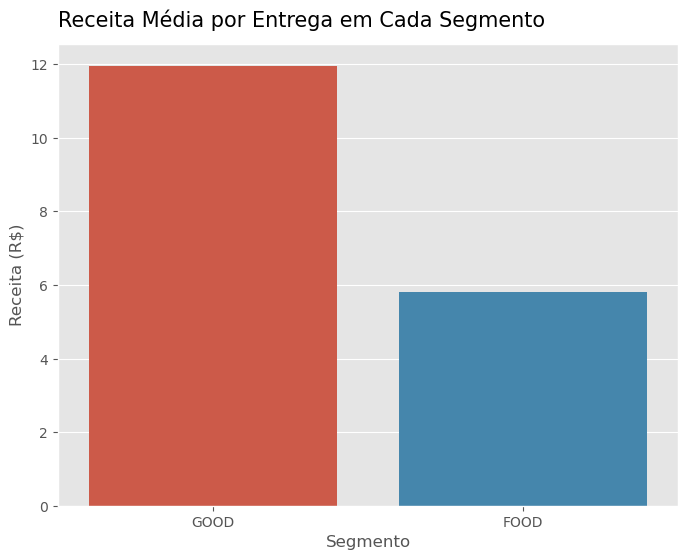

In [210]:
fig, ax = plt.subplots(figsize = (8, 6))

sns.barplot(segment_mean_revenue, x = 'store_segment', y = 'mean_revenue')
ax.set_title('Receita Média por Entrega em Cada Segmento', fontsize = 15, pad = 12, loc = 'left')
ax.set_xlabel('Segmento', fontsize = 12)
ax.set_ylabel('Receita (R$)', fontsize = 12)

In [211]:
# Receitas totais
segment_total_revenue = df.groupby(['store_segment'])\
.agg(total_revenue = ('order_revenue', 'sum'))\
.sort_values(by = 'store_segment', ascending = False).reset_index()
segment_total_revenue['total_revenue'] = segment_total_revenue['total_revenue'].round(2)
segment_total_revenue

,store_segment,total_revenue
0,GOOD,266027.68
1,FOOD,2073005.87


Text(0, 0.5, 'Receita (R$ x 1.000.000)')

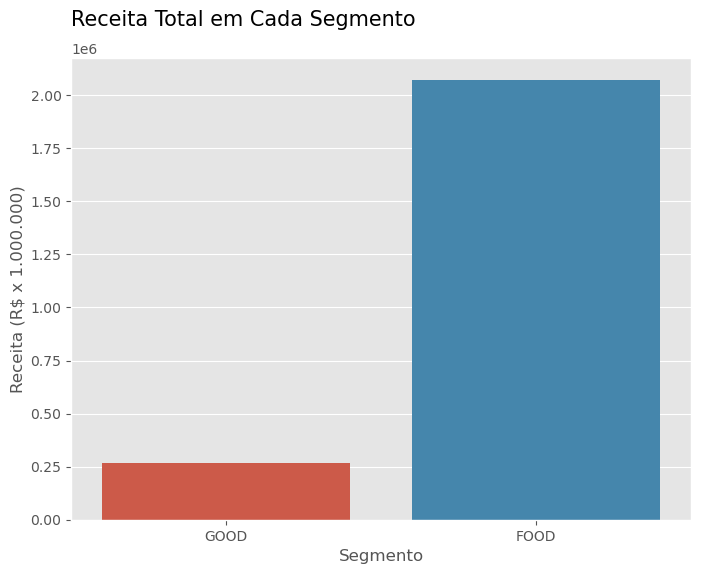

In [212]:
fig, ax = plt.subplots(figsize = (8, 6))

sns.barplot(segment_total_revenue, x = 'store_segment', y = 'total_revenue')
ax.set_title('Receita Total em Cada Segmento', fontsize = 15, pad = 12, loc = 'left')
ax.set_xlabel('Segmento', fontsize = 12)
ax.set_ylabel('Receita (R$ x 1.000.000)', fontsize = 12)

### Receitas médias e totais por estado

In [213]:
# Receita média
state_mean_revenue = df.groupby('hub_state').agg(mean_revenue = ('order_revenue', 'mean')).reset_index()
state_mean_revenue['mean_revenue'] = state_mean_revenue['mean_revenue'].round(2)
state_mean_revenue

,hub_state,mean_revenue
0,PR,2.05
1,RJ,6.30
2,RS,3.69
3,SP,7.46


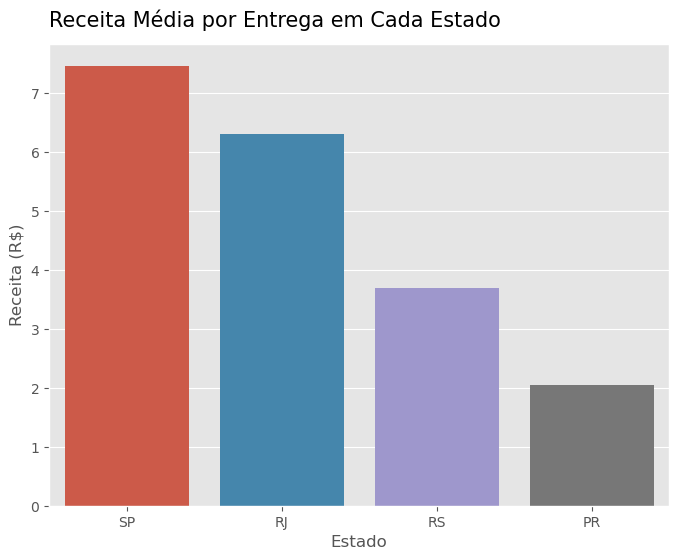

In [220]:
state_mean_revenue.sort_values(by = 'mean_revenue', ascending = False, inplace = True)

fig, ax = plt.subplots(figsize = (8, 6))

sns.barplot(state_mean_revenue, x = 'hub_state', y = 'mean_revenue')
ax.set_title('Receita Média por Entrega em Cada Estado', fontsize = 15, pad = 12, loc = 'left')
ax.set_xlabel('Estado', fontsize = 12)
ax.set_ylabel('Receita (R$)', fontsize = 12)
plt.show()

In [215]:
# Receitas totais
state_total_revenue = df.groupby('hub_state').agg(total_revenue = ('order_revenue', 'sum')).reset_index()
state_total_revenue['total_revenue'] = state_total_revenue['total_revenue'].round(2)
state_total_revenue

,hub_state,total_revenue
0,PR,66294.59
1,RJ,926442.74
2,RS,137065.08
3,SP,1209231.14


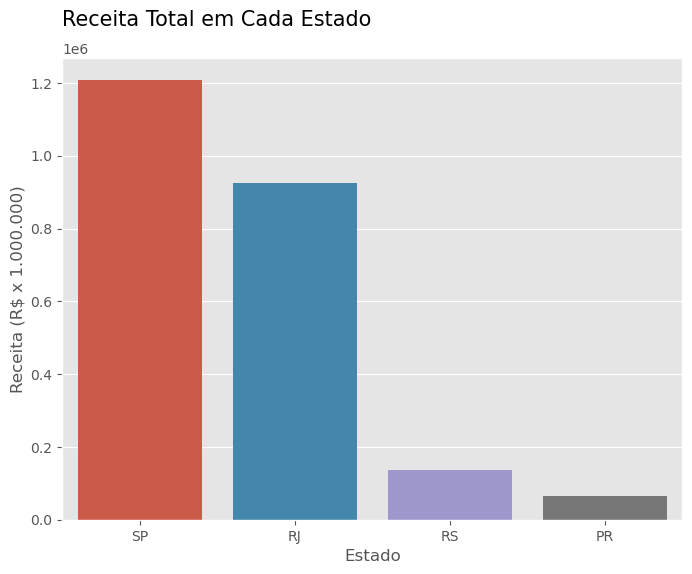

In [221]:
state_total_revenue.sort_values(by = 'total_revenue', ascending = False, inplace = True)

fig, ax = plt.subplots(figsize = (8, 6))

sns.barplot(state_total_revenue, x = 'hub_state', y = 'total_revenue')
ax.set_title('Receita Total em Cada Estado', fontsize = 15, pad = 12, loc = 'left')
ax.set_xlabel('Estado', fontsize = 12)
ax.set_ylabel('Receita (R$ x 1.000.000)', fontsize = 12)
plt.show()

## 3.4. Bônus para os funcionários

In [217]:
print(f"O bônus para cada funcionário será de R$ {(((df.order_revenue.sum()) * 0.20) / 2000).round(2)}")

O bônus para cada funcionário será de R$ 233.9
